# Análisis de supervivencia

## Objetivos de la sesión
* Introducción al análisis de supervivencia
* Introducción de las estimaciones de Kaplan-Meier
* Realización de un análisis de supervivencia de datos de eventos
* Visualización y comparación de curvas de supervivencia
* Realización de un análisis de supervivencia para cohortes desde diferentes perspectivas

## Introducción
El análisis de supervivencia es un tema importante en el análisis de dataos que rara vez recibe la atención que merece. Como su nombre indica, fue desarrollado originalmente para cuantificar y medir la duración de la vida de los individuos (qué tan probable era que alguien muriera o sobreviviera). Por ejemplo, si quisiéramos saber cuál es la probabilidad de muerte a lo largo del tiempo para cierto grupo de personas que han contraído alguna enfermedad, utilizaríamos el análisis de supervivencia. Sin embargo, las técnicas utilizadas en el análisis de supervivencia pueden aplicarse a una amplia variedad de situaciones.

En esta lección, vamos a cubrir los conceptos básicos del análisis de supervivencia para que se pueda aprovechar este valioso conjunto de técnicas en los análisis que se realicen en el futuro. Para ello, necesitaremos instalar una nueva biblioteca de Python llamada `lifelines` que se utiliza específicamente para realizar análisis de supervivencia.

In [ ]:
$ pip install lifelines

Importaremos los componentes de la librería un poco más tarde a medida que los necesitemos. También vamos a usar Pandas en esta lección, así como Plotly y Cufflinks, así que sigamos adelante e importémoslos.

In [1]:
import pandas as pd
import plotly.plotly as py
import cufflinks as cf

cf.go_offline()

## Análisis de supervivencia

El análisis de supervivencia se puede realizar en varios escenarios:

* Estimación de la duración de la vida humana
* Estimación de las fallas mecánicas a lo largo del tiempo
* Estimación de la duración de la retención de clientes
* Estimación del tiempo de recuperación de las enfermedades

Existen ciertos requisitos para realizar un análisis de supervivencia. El primero de ellos es que es necesario tener un campo en los datos que represente la ocurrencia (o falta de ella) de un evento.

El segundo requisito es que se necesita tener un campo que represente el paso del tiempo de alguna manera. Puede ser una fecha o un número que aumenta con el paso del tiempo, como el número de días/semanas/meses/años, el número de usos, la distancia recorrida, etc.

El tercer y último requisito es que se necesita tener al menos un campo para agruparlo. El análisis de supervivencia calcula las tasas de supervivencia para grupos que tienen algo en común. Si se dispone de varios escenarios por los que se puede agrupar, se puede realizar el análisis de los grupos representados por cada escenario individualmente o se pueden combinar en segmentos más granulares y examinar las tasas de supervivencia de los mismos. Sin embargo, sólo se puede hacer hasta un punto en el que el número de ejemplos en un grupo se vuelve demasiado pequeño para calcular de forma fiable sus tasas de supervivencia. Por lo tanto, es necesario equilibrar la capacidad de desglose en detalles granulares frente a la necesidad de tener grupos suficientemente grandes para calcular tasas de supervivencia significativas y fiables.

## Los datos
Los datos con los que trabajaremos en esta lección serán los datos de abandono de clientes de lecciones anteriores. Estos datos cumplen con los tres criterios mencionados anteriormente. Contiene un campo de evento (ChurnBinary) que indica si un cliente se ha dado de baja o no. Contiene un campo que representa el paso del tiempo (permanencia). Y finalmente, contiene varios campos categóricos por los cuales podemos agrupar a los clientes para que podamos explorar sus tasas de retención desde diferentes perspectivas.

Vamos a importar los datos que se pueden descargar [aquí](https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/data-static/data/module-2/churn.csv)

In [2]:
data = pd.read_csv('./data/churn.csv')

## Realización de un análisis de supervivencia
Ahora que hemos identificado los datos que queremos utilizar y los campos correspondientes, podemos comenzar nuestro análisis. El objetivo de nuestro análisis va a ser obtener una idea de la disminución de las tasas de retención de clientes a medida que aumenta la permanencia entre los diferentes grupos de clientes que tenemos en nuestro conjunto de datos.

La manera más fácil de hacer esto en Python es con la biblioteca `lifelines`. Vamos a importar la función `KaplanMeierFitter` desde `lifelines`. Las curvas de Kaplain-Meier son una de las técnicas estadísticas más comunes utilizadas en el análisis de supervivencia, y nos ayudarán a estimar la función de supervivencia de las diferentes cohortes que designamos (por ejemplo, hombres vs. mujeres, personas mayores vs. no mayores, etc.).

In [3]:
from lifelines import KaplanMeierFitter

A partir de aquí, vamos a definir una función `survival` que va a aceptar un conjunto de datos y luego especificar cada uno de los tres componentes necesarios para llevar a cabo un análisis de supervivencia (un campo de grupo, un campo de tiempo y un campo de eventos). Dentro de la función, vamos a definir nuestro modelo y luego crear una lista vacía en la que vamos a guardar nuestros resultados. A partir de ahí, hacemos un bucle a través de cada uno de los valores únicos en el campo de grupo, tomamos los datos en los campos de tiempo y evento, ajustamos nuestro modelo a los datos y añadimos los resultados de la función de supervivencia a nuestra lista de resultados. Al final, concatenamos los datos para cada valor de campo de grupo único y luego devolvemos los resultados.

In [4]:
def survival(data, group_field, time_field, event_field):
    model = KaplanMeierFitter()
    results = []
    
    for i in data[group_field].unique():
        group = data[data[group_field]==i]
        T = group[time_field]
        E = group[event_field]
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    return survival

Una vez que tenemos esta función, es relativamente fácil generar curvas de supervivencia para cualquiera de las cohortes de nuestro conjunto de datos. Por ejemplo, si quisiéramos visualizar las tasas de retención en el tiempo por género, podríamos hacerlo con sólo un par de líneas de código.

In [7]:
rates = survival(data, 'gender', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Gender')

Podemos ver que en la permanencia 0, ambas curvas de supervivencia comienzan en 1 (100%). La curva femenina luego disminuye un poco más rápido que la curva masculina y luego ambas continúan disminuyendo gradualmente hasta que superan los 60 meses, momento en el cual la curva masculina realiza una inmersión más pronunciada por debajo de las tasas de retención femenina. Ambas curvas terminan alrededor de la marca del 60%, lo que significa que después de 70 meses de permanencia en el mercado, un cliente tiene aproximadamente un 40% de probabilidades de sufrir un churn (tasa de retención del 60%).

Usando nuestra función, podemos fácilmente intercambiar los campos de grupo para echar un vistazo a las tasas de supervivencia desde diferentes perspectivas. Aquí están las curvas de supervivencia para personas mayores y no mayores.

In [8]:
rates = survival(data, 'SeniorCitizen', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Senior Citizen')

Desde esta perspectiva, podemos ver que la curva de supervivencia de las personas mayores tiene una pendiente más pronunciada que la de los no mayores, lo que hace que terminen con una tasa de retención muy inferior a la de los no mayores.

¿Qué tal si definimos nuestros cohortes alrededor del tipo de servicio de Internet que el cliente tiene en lugar de su demografía?

In [9]:
rates = survival(data, 'InternetService', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Internet Service')

Desde esta perspectiva, podemos ver que los clientes sin servicio de Internet tienden a tener tasas de retención más altas que los que sí lo tienen. Entre los que sí tienen servicio de Internet con la empresa, los que tienen DSL tienen tasas de retención mucho más altas en comparación con los que tienen fibra óptica, quizás porque esta última tiende a ser significativamente más cara.

La compañía también ofrece a los clientes la opción de firmar contratos de un año o dos años en lugar de simplemente pagar por sus servicios mes a mes. Veamos cómo se ven las curvas de supervivencia para cada una de esas tres opciones.

In [10]:
rates = survival(data, 'Contract', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Senior Citizen')

Como era de esperar, los clientes con contratos de dos años tienen las tasas de retención más altas, incluso más allá de los 24 meses (2 años). Los clientes con contratos de un año tienen altas tasas de retención hasta los 40 meses aproximadamente, y luego la tasa a la que se produce el churn aumenta. Y finalmente, los clientes que pagan mes a mes empiezan a darse de baja casi de inmediato con un descenso muy pronunciado en la retención entre 0 y 10 meses y luego se nivelan ligeramente, pero todavía bastante pronunciado.

## Utilidad del análisis de supervivencia
Como vimos anteriormente, el análisis de supervivencia es útil para obtener información sobre los factores que más importan cuando se tienen datos de eventos a lo largo del tiempo. En nuestro caso, pudimos observar las curvas de supervivencia estimando qué porcentaje de clientes retendría la compañía y qué porcentaje es probable que cambie con el tiempo desde diferentes perspectivas.

Esto es útil para las empresas, ya que les permite estimar cuándo es más probable que un cliente cancele su servicio. La empresa podría entonces determinar el momento adecuado para intervenir y ofrecer al cliente una actualización con descuento o un precio más bajo en el servicio que tiene actualmente (tal vez vinculado a un contrato de uno o dos años) para evitar que se marchen y aumentar así sus tasas de retención.

## Resumen
En esta lección, cubrimos los conceptos básicos del análisis de supervivencia en Python. Introdujimos la biblioteca de `lifelines` así como las curvas de Kaplan-Meier y luego las usamos para ajustar el modelo a los datos de grupo, evento y tiempo que teníamos para generar funciones de supervivencia para cada cohorte. Realizamos este análisis desde diferentes perspectivas para tener una mejor idea de los factores que más influyen en los índices de churn.

## Extra: Uso del Modelo de riesgo proporcional de Cox

El tiempo que transcurre hasta el evento para un individuo en la población es muy importante para las curvas de supervivencia a nivel agregado; sin embargo, en situaciones de la vida real junto con los datos del evento también tenemos las covariables (características) de ese individuo. En tales casos, es muy importante conocer el impacto de las covariables en la curva de supervivencia. Esto nos ayudaría a predecir la probabilidad de supervivencia de un individuo, si conocemos los valores de las covariables asociadas.
Por ejemplo, en el ejemplo de telco-churn analizado anteriormente, tenemos el tiempo de permanencia de cada cliente al momento de la baja (el tiempo del evento T) y el Sexo, Cargos Mensuales, Dependientes, Socio, Servicio Telefónico, etc. del cliente. Las otras variables son las covariables de este ejemplo. A menudo nos interesa saber cómo afectan estas covariables a la función de probabilidad de supervivencia.
En tales casos, se tratará de la función de supervivencia condicional S(t|x) = P(T > t|x). Aquí x denota las covariables. En nuestro ejemplo, estamos interesados en S(tenencia > t|(Género, Cargos Mensuales, Dependientes, Socio, Servicio Telefónico, etc)).
El modelo de Cox (riesgo proporcional) es uno de los modelos más populares que combina las covariables y la función de supervivencia. 

La idea detrás del modelo es que el log-hazard de un individuo es una función lineal de sus covariables estáticas, y un riesgo a nivel de la población que cambia con el tiempo. 

### Implementación básica en python:
Ahora discutiremos sobre su implementación básica en python con la ayuda del paquete `lifelines`. Hemos utilizado el mismo conjunto de datos de telco-customer-churn, que hemos estado utilizando en las secciones anteriores. Vamos a ejecutar un código python para predecir la función de supervivencia a nivel de cliente.

In [14]:
from lifelines import CoxPHFitter

In [12]:
df_r= data[['tenure', 'Churn', 'gender', 'Partner', 'Dependents', 'PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head()

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,No,Female,Yes,No,No,29.85,0,No
1,34,No,Male,No,No,Yes,56.95,0,No
2,2,Yes,Male,No,No,Yes,53.85,0,No
3,45,No,Male,No,No,No,42.30,0,No
4,2,Yes,Female,No,No,Yes,70.70,0,No


In [13]:
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,MonthlyCharges,SeniorCitizen,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,29.85,0,0,0,1,0,0,0,0
1,34,56.95,0,0,1,0,0,1,0,0
2,2,53.85,0,1,1,0,0,1,0,0
3,45,42.30,0,0,1,0,0,0,0,0
4,2,70.70,0,1,0,0,0,1,0,0


In [32]:
# Uso del modelo de riesgo proporcional de Cox
cph = CoxPHFitter()   ##  creamos el objeto cph que consiste en el modelo CoxPH
cph.fit(df_dummy, 'tenure', event_col='Churn_Yes')   ## Ajustamos nuestros datos al modelo creado
cph.print_summary()    ## imprimimos el resumen del modelo ajustado a nuestros datos para comprobar la significación de cada covariable sobre el modelo de riesgo

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn_Yes'
number of subjects = 7032
  number of events = 1869
partial log-likelihood = -15182.39
  time fit was run = 2019-08-06 11:18:20 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
MonthlyCharges                  -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
SeniorCitizen                    0.40      1.49      0.06            0.29            0.50                1.33                1.66
gender_Male                     -0.01      0.99      0.05           -0.10            0.08                0.90                1.08
Partner_Yes                     -0.81      0.45      0.05           -0.92           -0.70                0.40                0.50
Dependents_Yes                  -0.36      0.70      0.07           -0.49       

En los resultados podemos ver que todas las variables parecen tener un efecto significativo sobre la supervivencia del usuario en el servicio menos en género. Esto es lo mismo que podemos interpretar con el gráfico a continuación.

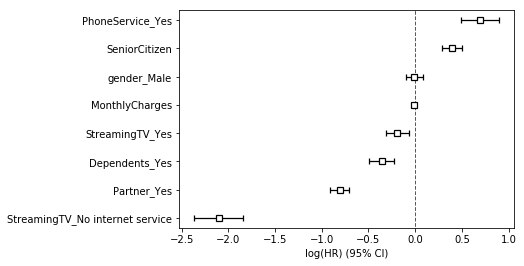

In [21]:
%matplotlib inline
cph.plot()

In [25]:
## También podemos utilizar el modelo creado para predecir nuevos comportamientos de clientes.
# Para ello necesitamos las covariables introducidas en el modelo en el mismo formato

tr_rows = df_dummy.iloc[5:10,:]
tr_rows


,tenure,MonthlyCharges,SeniorCitizen,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,8,99.65,0,1,0,0,0,1,0,1
6,22,89.10,0,0,1,0,1,1,0,1
7,10,29.75,0,0,0,0,0,0,0,0
8,28,104.80,0,1,0,1,0,1,0,1
9,62,56.15,0,0,1,0,1,1,0,0


In [33]:
## Si trazamos un gráfico de líneas con los resultados de las predicciones podemos ver cómo se ajusta el modelo para cada sujeto
tr_rows_pred = cph.predict_survival_function(tr_rows)
tr_rows_pred.iplot(kind="line")